In [1]:
import sys

#import params_Jay as params
#params.set_gpu_env()

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchsummary import summary
from torch.utils.data import TensorDataset, DataLoader

import cmasher as cmr

from tqdm import tqdm 
import numpy as np
from skimage.transform import resize
from sklearn.metrics import mean_squared_error

import matplotlib.pyplot as plt
import matplotlib

import os
import glob

from sklearn.utils import shuffle
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.cluster import DBSCAN, KMeans, SpectralClustering, AgglomerativeClustering, OPTICS
from sklearn.cluster import *
from sklearn import cluster
from sklearn.preprocessing import StandardScaler
from sklearn.mixture import GaussianMixture, BayesianGaussianMixture
from sklearn.decomposition import PCA, KernelPCA, NMF
from sklearn.manifold import TSNE
from sklearn import manifold
from sklearn.metrics import silhouette_samples, silhouette_score
from skimage import filters
from umap import UMAP
import plotly.express as px


from scipy.signal import argrelextrema
import time
import pandas as pd

torch.__version__

image_cmap = plt.cm.inferno


class recon_encoder(nn.Module):

    def __init__(self, latent_size, nconv=16, pool=4, drop=0.05):
        super(recon_encoder, self).__init__()


        self.encoder = nn.Sequential( # Appears sequential has similar functionality as TF avoiding need for separate model definition and activ
          nn.Conv2d(in_channels=1, out_channels=nconv, kernel_size=3, stride=1, padding=(1,1)),
          nn.Dropout(drop),
          nn.ReLU(),
          nn.Conv2d(nconv, nconv, 3, stride=1, padding=(1,1)),
          nn.Dropout(drop),
          nn.ReLU(),
          nn.MaxPool2d((pool,pool)),

          nn.Conv2d(nconv, nconv*2, 3, stride=1, padding=(1,1)),
          nn.Dropout(drop),
          nn.ReLU(),
          nn.Conv2d(nconv*2, nconv*2, 3, stride=1, padding=(1,1)),
          nn.Dropout(drop),          
          nn.ReLU(),
          nn.MaxPool2d((pool,pool)),

          nn.Conv2d(nconv*2, nconv*4, 3, stride=1, padding=(1,1)),
          nn.Dropout(drop),
          nn.ReLU(),
          nn.Conv2d(nconv*4, nconv*4, 3, stride=1, padding=(1,1)),     
          nn.Dropout(drop),     
          nn.ReLU(),
          nn.MaxPool2d((pool,pool)),

          #nn.Conv2d(nconv*4, nconv*4, 3, stride=1, padding=(1,1)),
          #nn.Dropout(drop),
          #nn.ReLU(),
          #nn.Conv2d(nconv*4, nconv*4, 3, stride=1, padding=(1,1)),     
          #nn.Dropout(drop),     
          #nn.ReLU(),
          #nn.MaxPool2d((pool,pool)),
        )


        self.bottleneck = nn.Sequential(
          # FC layer at bottleneck -- dropout might not make sense here
          nn.Flatten(),
          nn.Linear(1024, latent_size),
          #nn.Dropout(drop),
          nn.ReLU(),
#          nn.Linear(latent_size, 1024),
#          #nn.Dropout(drop),
#          nn.ReLU(),
#          nn.Unflatten(1,(64,4,4))# 0 is batch dimension
          )


        self.decoder1 = nn.Sequential(

          nn.Conv2d(nconv*4, nconv*4, 3, stride=1, padding=(1,1)),
          nn.Dropout(drop),
          nn.ReLU(),
          nn.Conv2d(nconv*4, nconv*4, 3, stride=1, padding=(1,1)),
          nn.Dropout(drop),
          nn.ReLU(),
          nn.Upsample(scale_factor=pool, mode='bilinear'),

          nn.Conv2d(nconv*4, nconv*4, 3, stride=1, padding=(1,1)),
          nn.Dropout(drop),
          nn.ReLU(),
          nn.Conv2d(nconv*4, nconv*4, 3, stride=1, padding=(1,1)),
          nn.Dropout(drop),
          nn.ReLU(),
          nn.Upsample(scale_factor=pool, mode='bilinear'),

          nn.Conv2d(nconv*4, nconv*2, 3, stride=1, padding=(1,1)),
          nn.Dropout(drop),
          nn.ReLU(),
          nn.Conv2d(nconv*2, nconv*2, 3, stride=1, padding=(1,1)),
          nn.Dropout(drop),
          nn.ReLU(),
          nn.Upsample(scale_factor=pool, mode='bilinear'),
            
          #nn.Conv2d(nconv*2, nconv*2, 3, stride=1, padding=(1,1)),
          #nn.Dropout(drop),
          #nn.ReLU(),
          #nn.Conv2d(nconv*2, nconv*2, 3, stride=1, padding=(1,1)),
          #nn.Dropout(drop),
          #nn.ReLU(),
          #nn.Upsample(scale_factor=pool, mode='bilinear'),

          nn.Conv2d(nconv*2, 1, 3, stride=1, padding=(1,1)), #Output conv layer has 2 for mu and sigma
          nn.Sigmoid() #Amplitude mode
          )
    

    def forward(self,x):
        with torch.cuda.amp.autocast():
            x1 = self.encoder(x)
            x1 = self.bottleneck(x1)
            #print(x1.shape)
            return x1


    #Helper function to calculate size of flattened array from conv layer shapes    
    def calc_fc_shape(self):
        x0 = torch.zeros([256,256]).unsqueeze(0)
        x0 = self.encoder(x0)

        self.conv_bock_output_shape = x0.shape
        #print ("Output of conv block shape is", self.conv_bock_output_shape)
        self.flattened_size = x0.flatten().shape[0]
        #print ("Flattened layer size is", self.flattened_size)
        return self.flattened_size

class recon_model(nn.Module):

    def __init__(self, latent_size, nconv=16, pool=4, drop=0.05):
        super(recon_model, self).__init__()


        self.encoder = nn.Sequential( # Appears sequential has similar functionality as TF avoiding need for separate model definition and activ
          nn.Conv2d(in_channels=1, out_channels=nconv, kernel_size=3, stride=1, padding=(1,1)),
          nn.Dropout(drop),
          nn.ReLU(),
          nn.Conv2d(nconv, nconv, 3, stride=1, padding=(1,1)),
          nn.Dropout(drop),
          nn.ReLU(),
          nn.MaxPool2d((pool,pool)),

          nn.Conv2d(nconv, nconv*2, 3, stride=1, padding=(1,1)),
          nn.Dropout(drop),
          nn.ReLU(),
          nn.Conv2d(nconv*2, nconv*2, 3, stride=1, padding=(1,1)),
          nn.Dropout(drop),          
          nn.ReLU(),
          nn.MaxPool2d((pool,pool)),

          nn.Conv2d(nconv*2, nconv*4, 3, stride=1, padding=(1,1)),
          nn.Dropout(drop),
          nn.ReLU(),
          nn.Conv2d(nconv*4, nconv*4, 3, stride=1, padding=(1,1)),     
          nn.Dropout(drop),     
          nn.ReLU(),
          nn.MaxPool2d((pool,pool)),

          #nn.Conv2d(nconv*4, nconv*4, 3, stride=1, padding=(1,1)),
          #nn.Dropout(drop),
          #nn.ReLU(),
          #nn.Conv2d(nconv*4, nconv*4, 3, stride=1, padding=(1,1)),     
          #nn.Dropout(drop),     
          #nn.ReLU(),
          #nn.MaxPool2d((pool,pool)),
        )


        self.bottleneck = nn.Sequential(
          # FC layer at bottleneck -- dropout might not make sense here
          nn.Flatten(),
          nn.Linear(1024, latent_size),
          #nn.Dropout(drop),
          nn.ReLU(),
          nn.Linear(latent_size, 1024),
          #nn.Dropout(drop),
          nn.ReLU(),
          nn.Unflatten(1,(64,4,4))# 0 is batch dimension
          )


        self.decoder1 = nn.Sequential(

          nn.Conv2d(nconv*4, nconv*4, 3, stride=1, padding=(1,1)),
          nn.Dropout(drop),
          nn.ReLU(),
          nn.Conv2d(nconv*4, nconv*4, 3, stride=1, padding=(1,1)),
          nn.Dropout(drop),
          nn.ReLU(),
          nn.Upsample(scale_factor=pool, mode='bilinear'),

          nn.Conv2d(nconv*4, nconv*4, 3, stride=1, padding=(1,1)),
          nn.Dropout(drop),
          nn.ReLU(),
          nn.Conv2d(nconv*4, nconv*4, 3, stride=1, padding=(1,1)),
          nn.Dropout(drop),
          nn.ReLU(),
          nn.Upsample(scale_factor=pool, mode='bilinear'),

          nn.Conv2d(nconv*4, nconv*2, 3, stride=1, padding=(1,1)),
          nn.Dropout(drop),
          nn.ReLU(),
          nn.Conv2d(nconv*2, nconv*2, 3, stride=1, padding=(1,1)),
          nn.Dropout(drop),
          nn.ReLU(),
          nn.Upsample(scale_factor=pool, mode='bilinear'),
            
          #nn.Conv2d(nconv*2, nconv*2, 3, stride=1, padding=(1,1)),
          #nn.Dropout(drop),
          #nn.ReLU(),
          #nn.Conv2d(nconv*2, nconv*2, 3, stride=1, padding=(1,1)),
          #nn.Dropout(drop),
          #nn.ReLU(),
          #nn.Upsample(scale_factor=pool, mode='bilinear'),

          nn.Conv2d(nconv*2, 1, 3, stride=1, padding=(1,1)), #Output conv layer has 2 for mu and sigma
          nn.Sigmoid() #Amplitude mode
          )
    

    def forward(self,x):
        with torch.cuda.amp.autocast():
            x1 = self.encoder(x)
            x1 = self.bottleneck(x1)
            #print(x1.shape)
            return self.decoder1(x1)


    #Helper function to calculate size of flattened array from conv layer shapes    
    def calc_fc_shape(self):
        x0 = torch.zeros([256,256]).unsqueeze(0)
        x0 = self.encoder(x0)

        self.conv_bock_output_shape = x0.shape
        #print ("Output of conv block shape is", self.conv_bock_output_shape)
        self.flattened_size = x0.flatten().shape[0]
        #print ("Flattened layer size is", self.flattened_size)
        return self.flattened_size
    
class recon_decoder(nn.Module):

    def __init__(self, latent_size, nconv=16, pool=4, drop=0.05):
        super(recon_decoder, self).__init__()

        self.bottleneck = nn.Sequential(
            nn.Linear(latent_size, 1024),
            nn.ReLU(),
            nn.Unflatten(1,(64,4,4))
        )


        self.decoder1 = nn.Sequential(

          nn.Conv2d(nconv*4, nconv*4, 3, stride=1, padding=(1,1)),
          nn.Dropout(drop),
          nn.ReLU(),
          nn.Conv2d(nconv*4, nconv*4, 3, stride=1, padding=(1,1)),
          nn.Dropout(drop),
          nn.ReLU(),
          nn.Upsample(scale_factor=pool, mode='bilinear'),

          nn.Conv2d(nconv*4, nconv*4, 3, stride=1, padding=(1,1)),
          nn.Dropout(drop),
          nn.ReLU(),
          nn.Conv2d(nconv*4, nconv*4, 3, stride=1, padding=(1,1)),
          nn.Dropout(drop),
          nn.ReLU(),
          nn.Upsample(scale_factor=pool, mode='bilinear'),

          nn.Conv2d(nconv*4, nconv*2, 3, stride=1, padding=(1,1)),
          nn.Dropout(drop),
          nn.ReLU(),
          nn.Conv2d(nconv*2, nconv*2, 3, stride=1, padding=(1,1)),
          nn.Dropout(drop),
          nn.ReLU(),
          nn.Upsample(scale_factor=pool, mode='bilinear'),
            
          #nn.Conv2d(nconv*2, nconv*2, 3, stride=1, padding=(1,1)),
          #nn.Dropout(drop),
          #nn.ReLU(),
          #nn.Conv2d(nconv*2, nconv*2, 3, stride=1, padding=(1,1)),
          #nn.Dropout(drop),
          #nn.ReLU(),
          #nn.Upsample(scale_factor=pool, mode='bilinear'),

          nn.Conv2d(nconv*2, 1, 3, stride=1, padding=(1,1)), #Output conv layer has 2 for mu and sigma
          nn.ReLU()
            #nn.Sigmoid() #Amplitude mode
          )
    

    def forward(self,x):
        with torch.cuda.amp.autocast():
            #x1 = self.encoder(x)
            x1 = self.bottleneck(x)
            #print(x1.shape)
            return self.decoder1(x1)

/opt/anaconda3/envs/pytorch/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
rheo_images = np.load('analysis_data/E031_256.npy') ### needs to be downloaded from https://anl.app.box.com/s/dhqahh467gnv0srz0tct1ymaofgr07te
rheo_raw = rheo_images.reshape(-1,rheo_images.shape[1]*rheo_images.shape[2])  ### Test dataset, raw
rheo_encoded = np.load('analysis_data/full_dataset_AugmentedTraining_rheo64.npy')
rheo_sectors = np.load('analysis_data/E031_256_sectors.npy')
rheo_times = np.load('analysis_data/E031_256_start.npy')
rheo_data = pd.read_pickle('analysis_data/RheoData.pkl')

In [3]:
full_model = recon_model(latent_size=64)
full_model.load_state_dict(torch.load('AutoEncoder/weights/full_dataset_augmented_training_normbest_model_0051.pth',map_location=torch.device('cpu')))

summary(full_model,(1,256,256),device='cpu')

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 16, 256, 256]             160
           Dropout-2         [-1, 16, 256, 256]               0
              ReLU-3         [-1, 16, 256, 256]               0
            Conv2d-4         [-1, 16, 256, 256]           2,320
           Dropout-5         [-1, 16, 256, 256]               0
              ReLU-6         [-1, 16, 256, 256]               0
         MaxPool2d-7           [-1, 16, 64, 64]               0
            Conv2d-8           [-1, 32, 64, 64]           4,640
           Dropout-9           [-1, 32, 64, 64]               0
             ReLU-10           [-1, 32, 64, 64]               0
           Conv2d-11           [-1, 32, 64, 64]           9,248
          Dropout-12           [-1, 32, 64, 64]               0
             ReLU-13           [-1, 32, 64, 64]               0
        MaxPool2d-14           [-1, 32,

/opt/anaconda3/envs/pytorch/lib/python3.10/site-packages/torch/amp/autocast_mode.py:204: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


In [4]:
decoder_model = recon_decoder(latent_size=64)
decoder_state_dict = decoder_model.state_dict()

checkpoint = torch.load('AutoEncoder/weights/full_dataset_augmented_training_normbest_model_0051.pth',map_location=torch.device('cpu'))

checkpoint['bottleneck.0.weight'] = checkpoint['bottleneck.3.weight']
checkpoint['bottleneck.0.bias'] = checkpoint['bottleneck.3.bias']

pretrained_dict = {k: v for k, v in checkpoint.items() if k in decoder_state_dict}

decoder_model.load_state_dict(pretrained_dict)

<All keys matched successfully>

# Perform Clustering in Latent Space

In [5]:
### Umap embedding

reducer = UMAP(n_components=2,n_neighbors=5,min_dist=0.25,metric='euclidean',random_state=42)
embedding = reducer.fit_transform(rheo_encoded)

## Clustering Algorithms That Don't Require Cluster Number SPecification

In [7]:
start = time.time()
dbscan = cluster.DBSCAN()
dbscan_labels = dbscan.fit_predict(rheo_encoded)
print('DBSCAN')
print('\ttime: ',np.round(time.time() - start,3))

start = time.time()
optics = cluster.OPTICS()
optics_labels = optics.fit_predict(rheo_encoded)
print('OPTICS')
print('\ttime: ',np.round(time.time() - start,3))

start = time.time()
birch = cluster.Birch()
birch_labels = birch.fit_predict(rheo_encoded)
print('BIRCH')
print('\ttime: ',np.round(time.time() - start,3))

start = time.time()
mean_shift = cluster.MeanShift()
mean_shift_labels = mean_shift.fit_predict(rheo_encoded)
print('Mean Shift')
print('\ttime: ',np.round(time.time() - start,3))

start = time.time()
aff_prop = cluster.AffinityPropagation()
aff_prop_labels = aff_prop.fit_predict(rheo_encoded)
print('Affinity Propagation')
print('\ttime: ',np.round(time.time() - start,3))

start = time.time()
agg = cluster.AgglomerativeClustering(n_clusters=None,distance_threshold=1)
agg_labels = agg.fit_predict(rheo_encoded)
print('Agglomerative Clustering')
print('\ttime: ',np.round(time.time() - start,3))

DBSCAN
	time:  0.024
OPTICS
	time:  0.298
BIRCH
	time:  0.054
Mean Shift
	time:  2.544
Affinity Propagation
	time:  0.395
Agglomerative Clustering
	time:  0.013


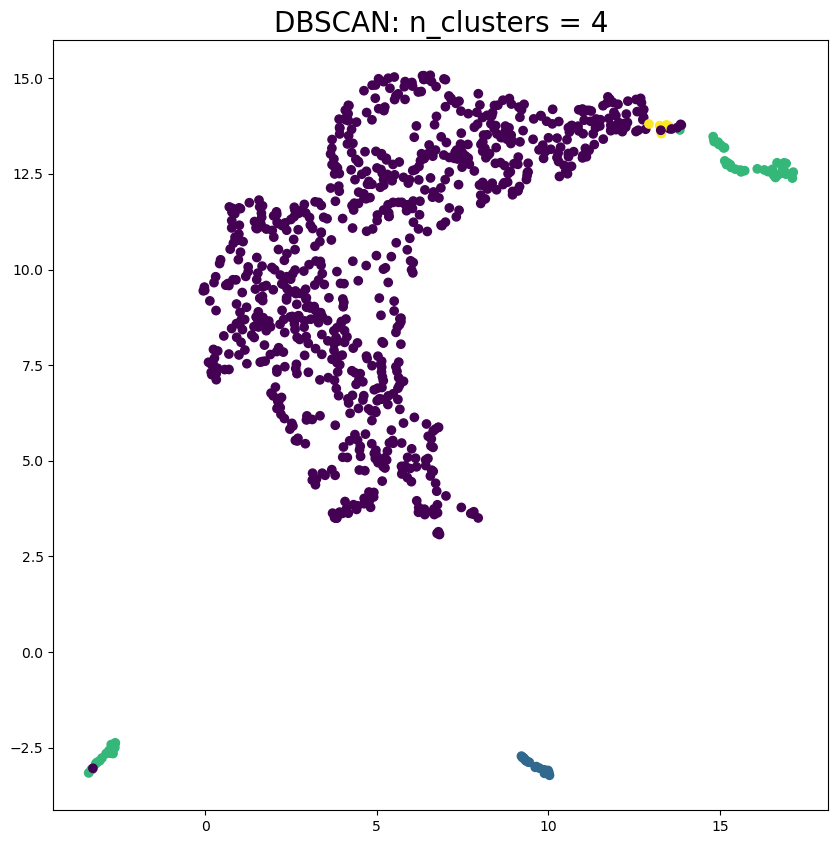

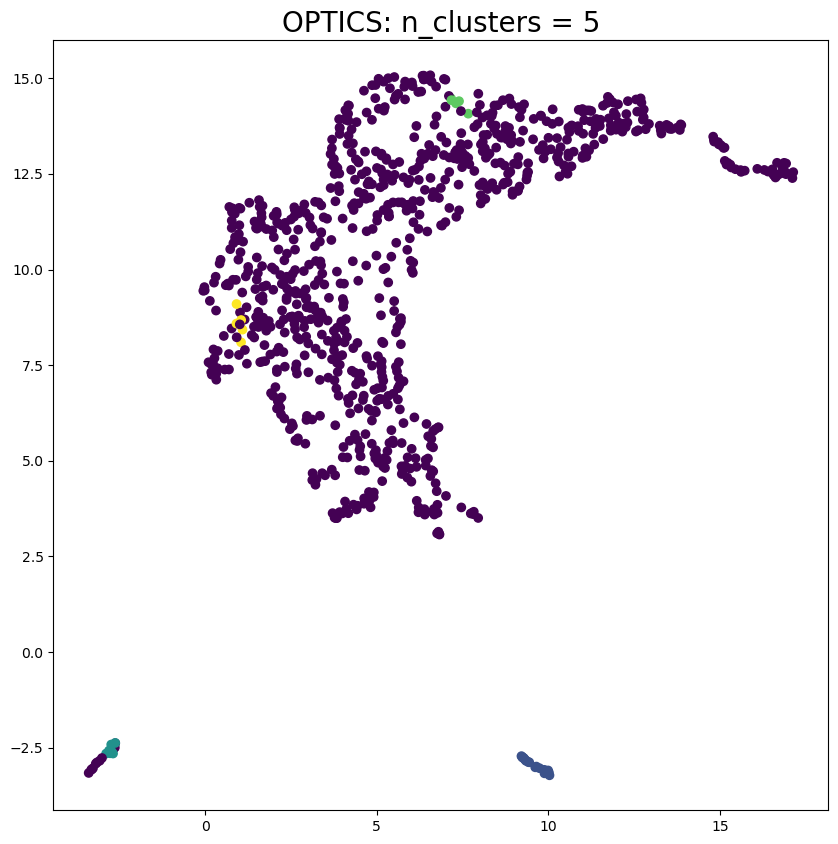

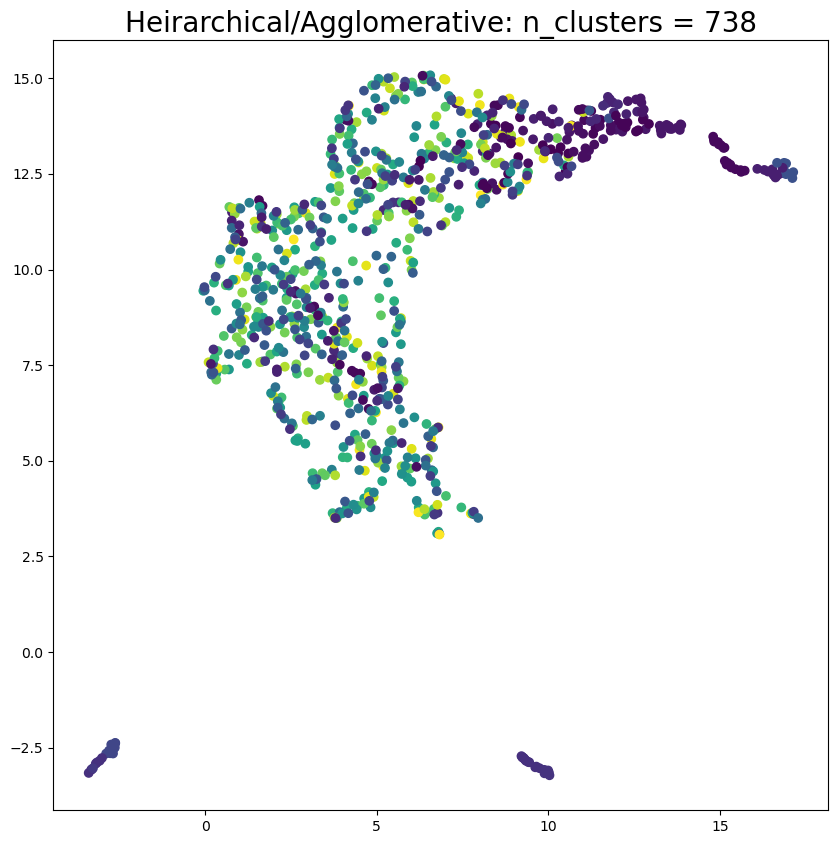

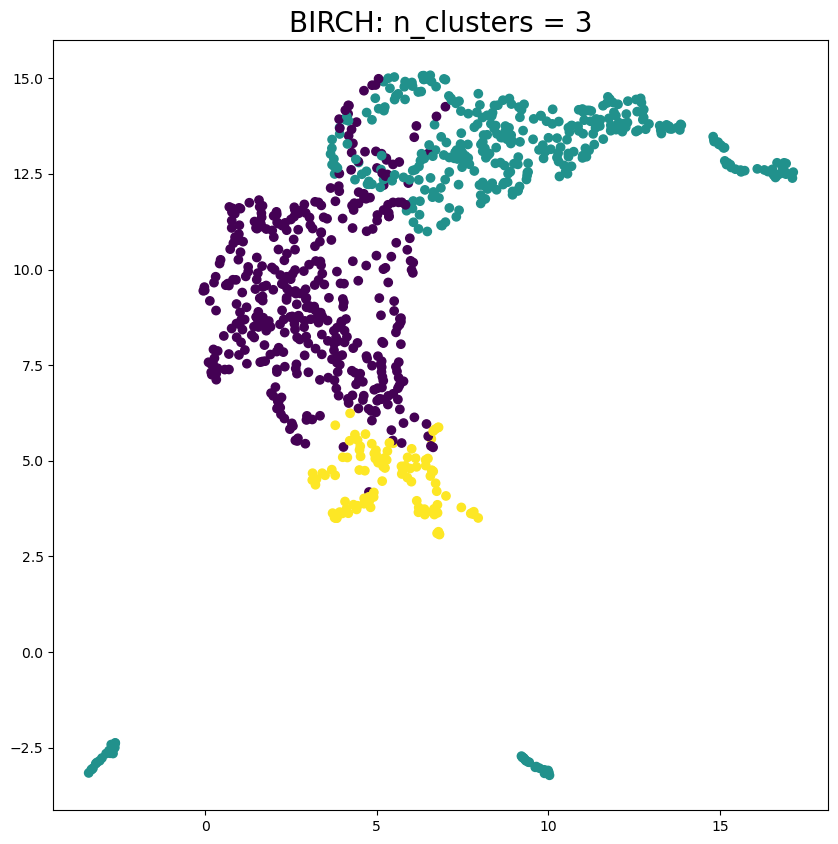

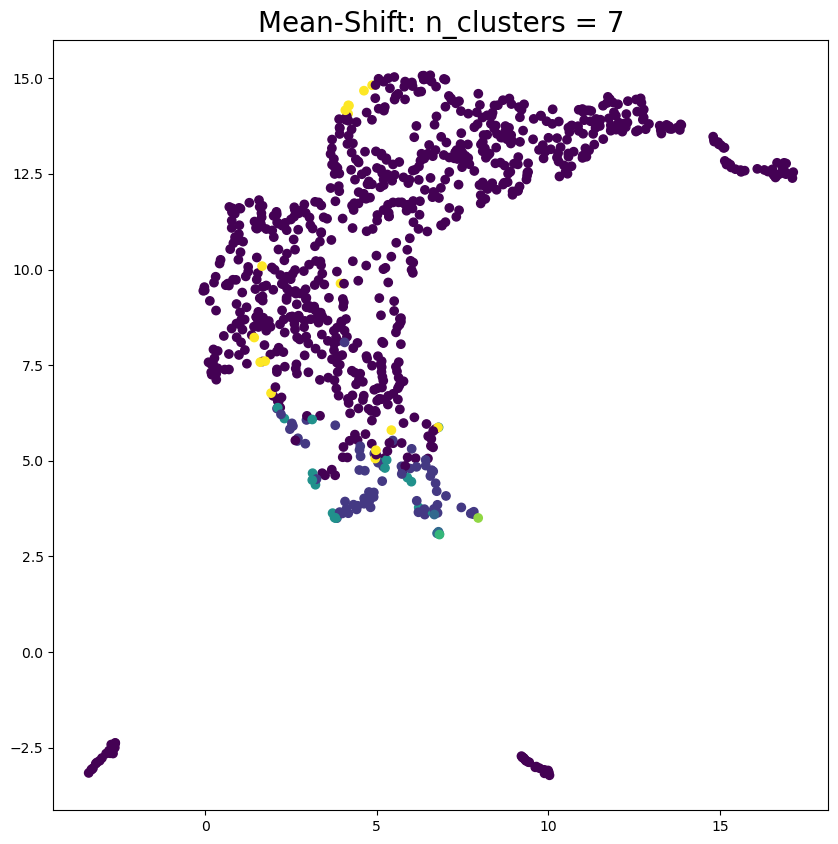

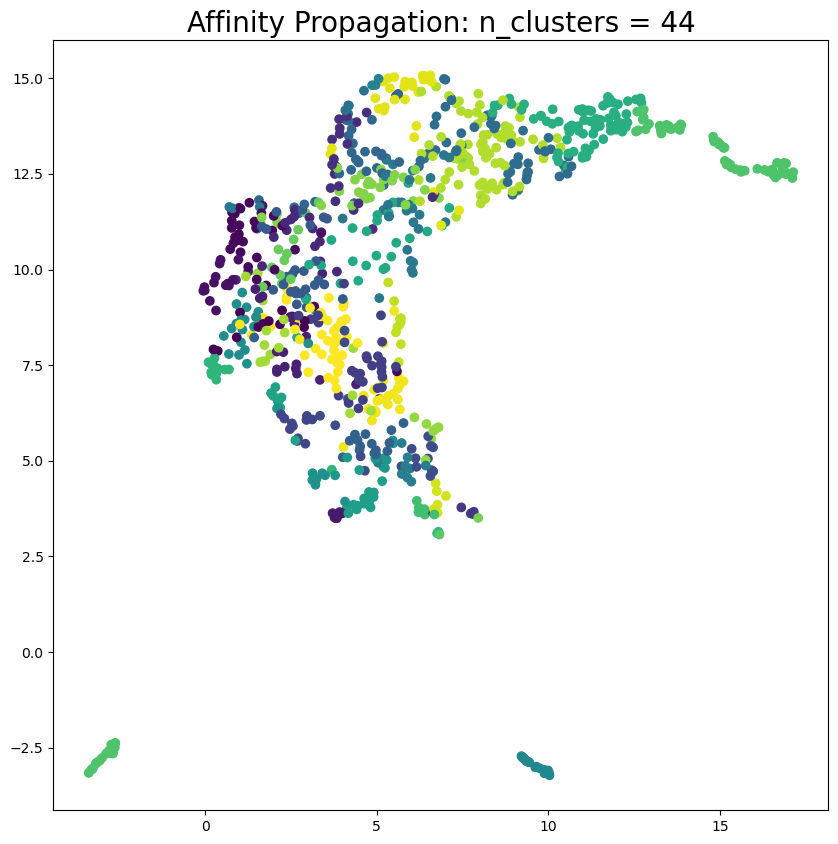

In [8]:
algos = ['DBSCAN', 'OPTICS', 'Heirarchical/Agglomerative', 'BIRCH', 'Mean-Shift', 'Affinity Propagation']
labels = [dbscan_labels, optics_labels, agg_labels, birch_labels, mean_shift_labels, aff_prop_labels]

for i in range(len(labels)):
    fig, ax = plt.subplots(figsize=(10,10))
    ax.scatter(embedding[:,0],embedding[:,1],c=labels[i])
    ax.set_title('{}: n_clusters = {}'.format(algos[i],len(np.unique(labels[i]))),fontsize=20)

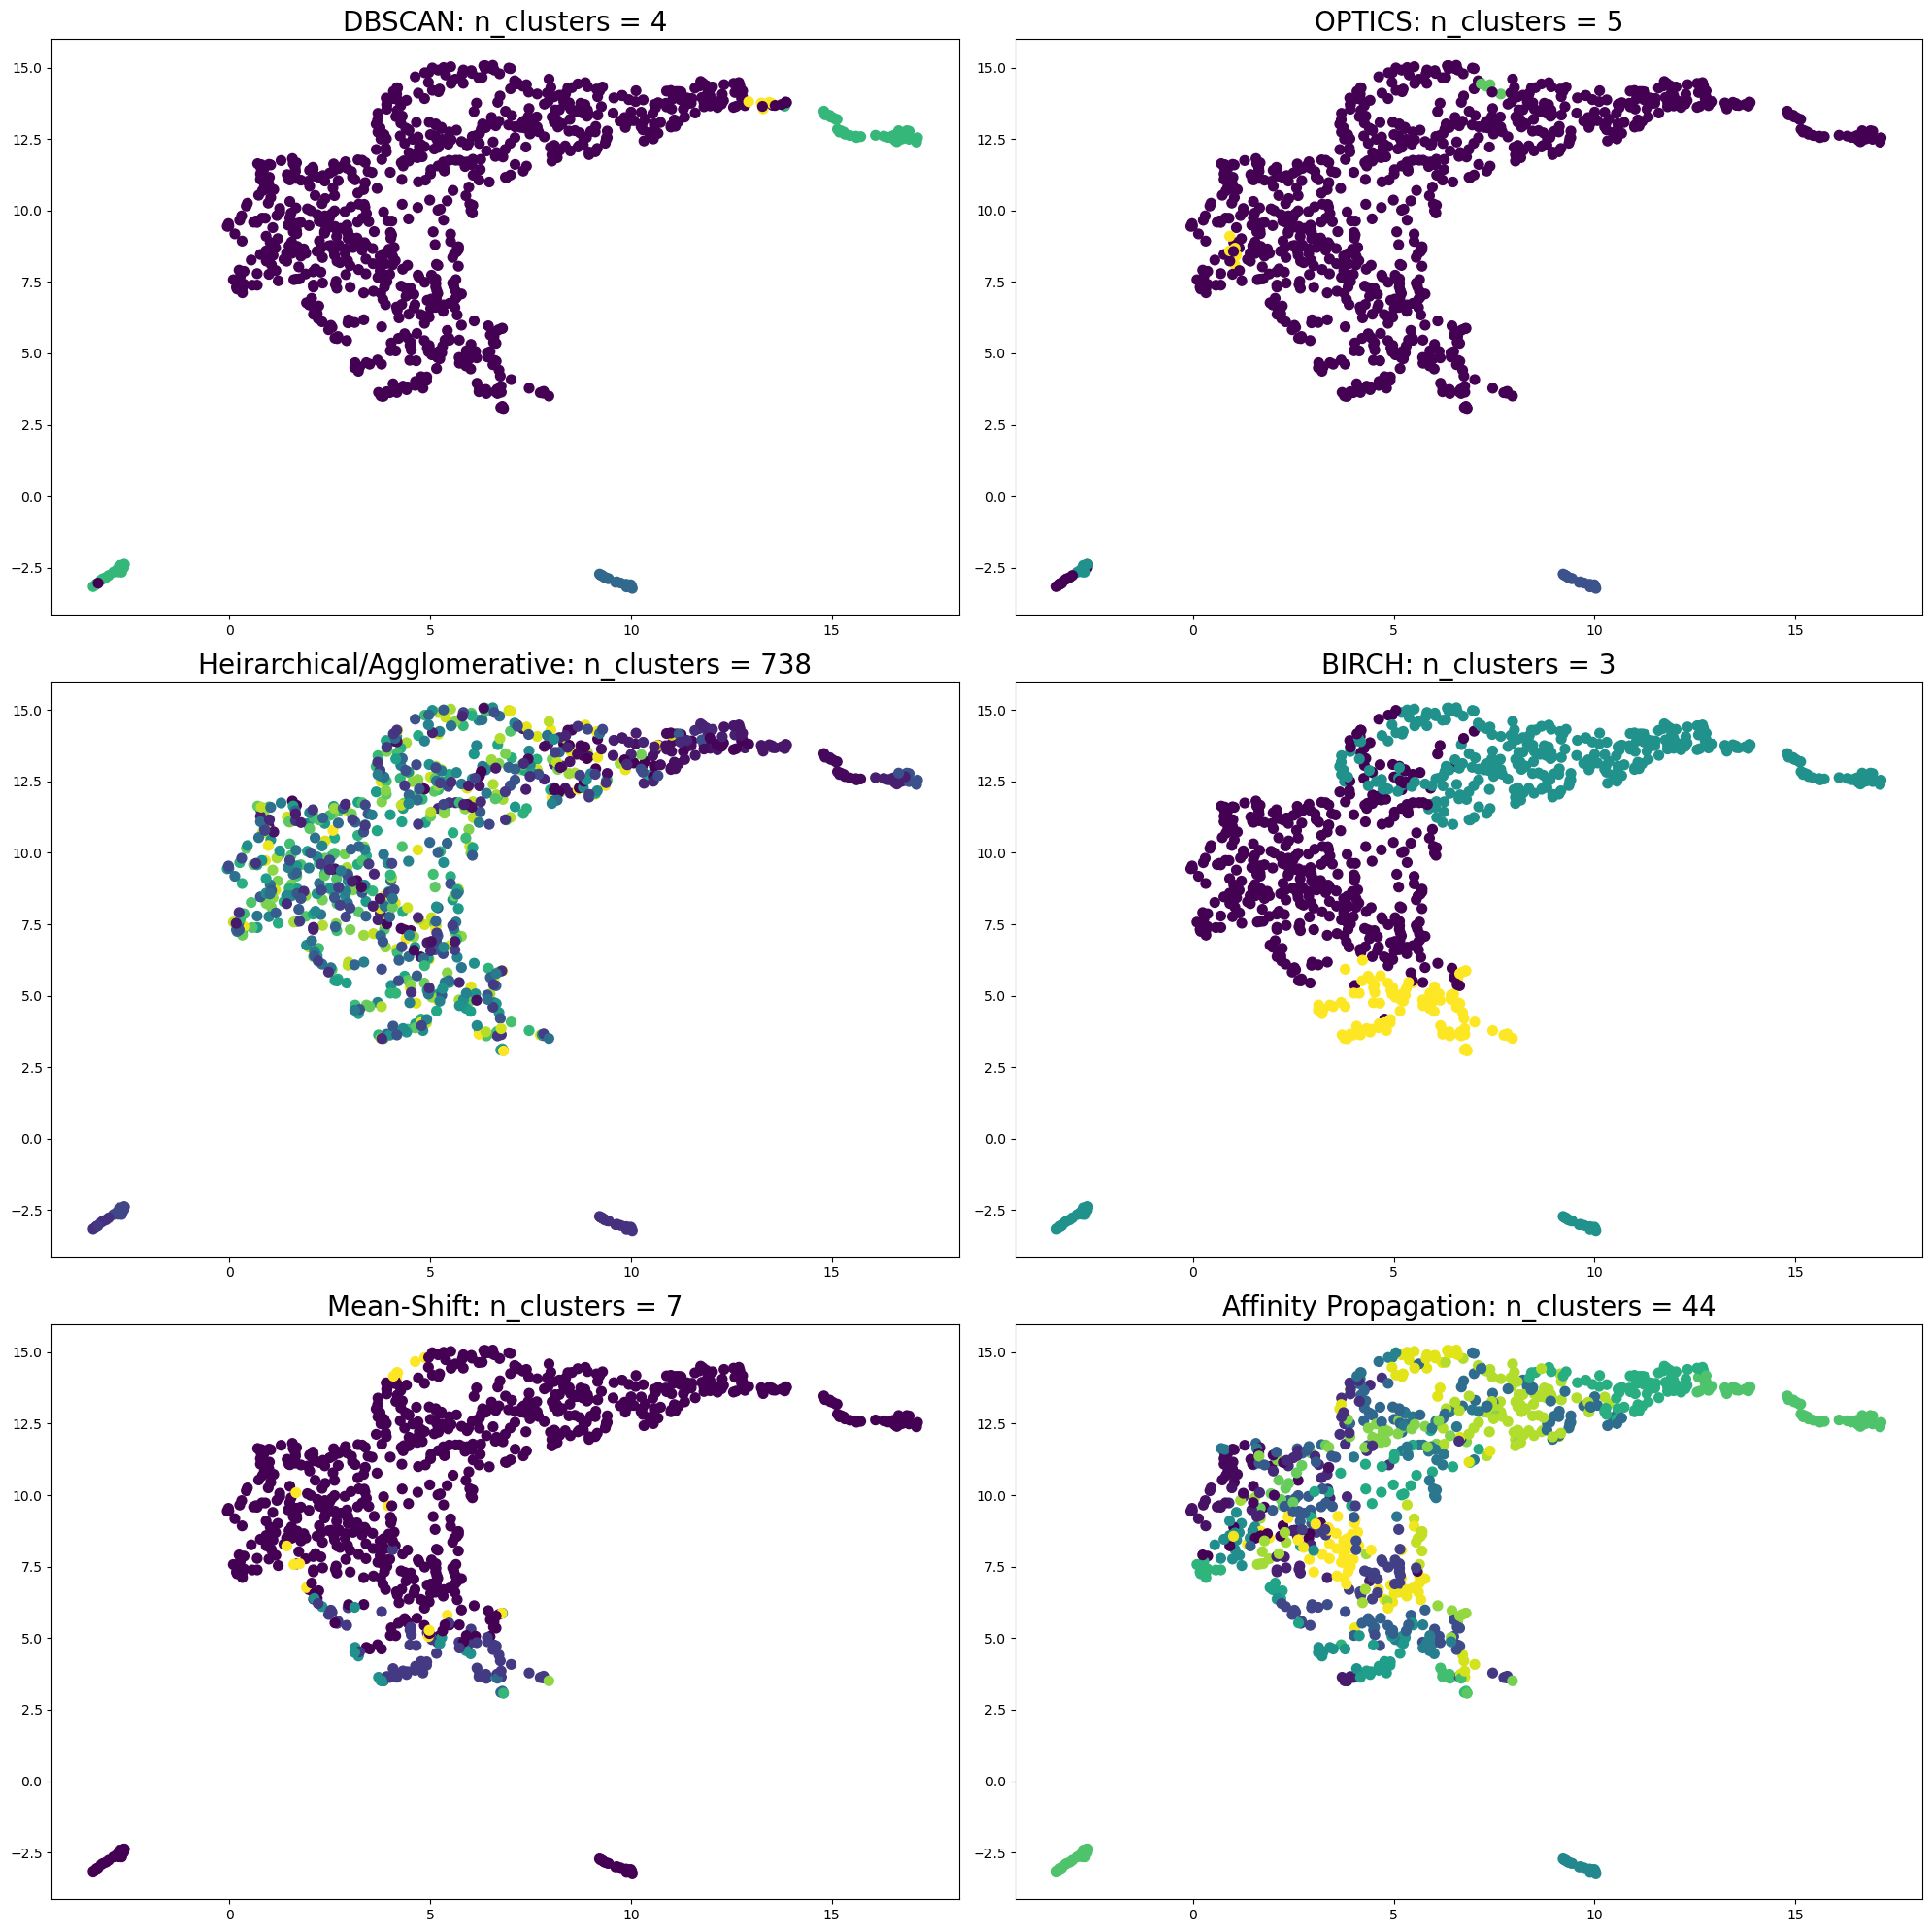

In [17]:
fig = plt.figure(figsize=(20,20))
n_rows, n_cols = 3,2

for i in range(len(labels)):
    ax = fig.add_subplot(n_rows, n_cols, i + 1)
    ax.scatter(embedding[:,0],embedding[:,1],c=labels[i],s=50)
    ax.set_title('{}: n_clusters = {}'.format(algos[i],len(np.unique(labels[i]))),fontsize=20)
fig.tight_layout()
fig.savefig('new_figures/Clustering_Algo_Comparison.pdf')

In [12]:
birch_original_labels = birch_labels.copy()

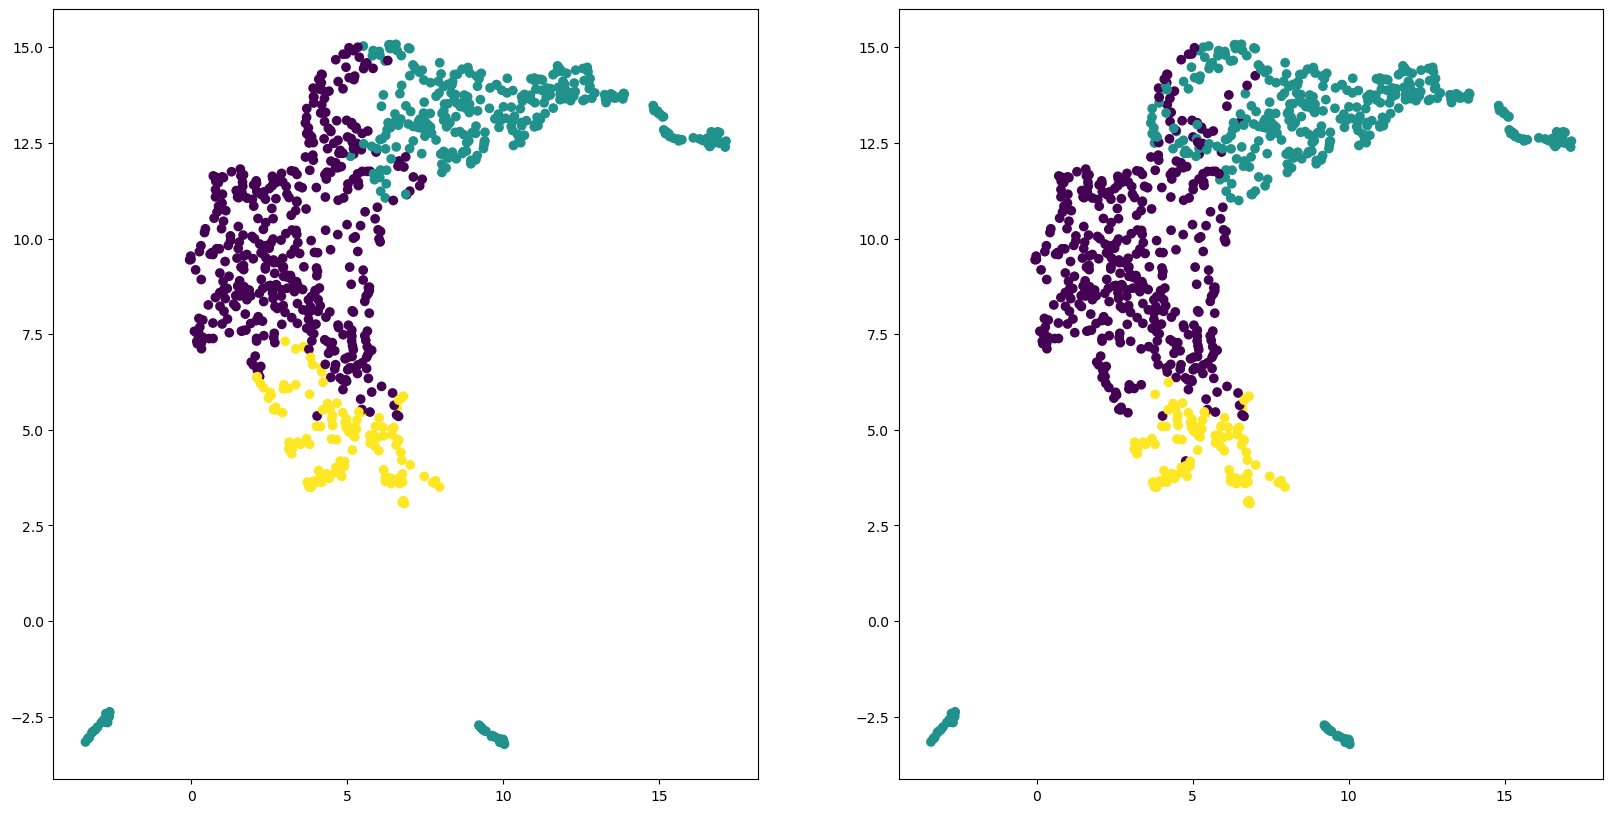

In [21]:
### Try to Optimize BIRCH
birch = cluster.Birch(threshold=0.25,branching_factor=10)
birch_labels = birch.fit_predict(rheo_encoded)

fig, ax = plt.subplots(figsize=(20,10),ncols=2)
ax[0].scatter(embedding[:,0],embedding[:,1],c=birch_labels)

ax[1].scatter(embedding[:,0],embedding[:,1],c=birch_original_labels)

In [22]:
aff_prop_labels_original = aff_prop_labels.copy()

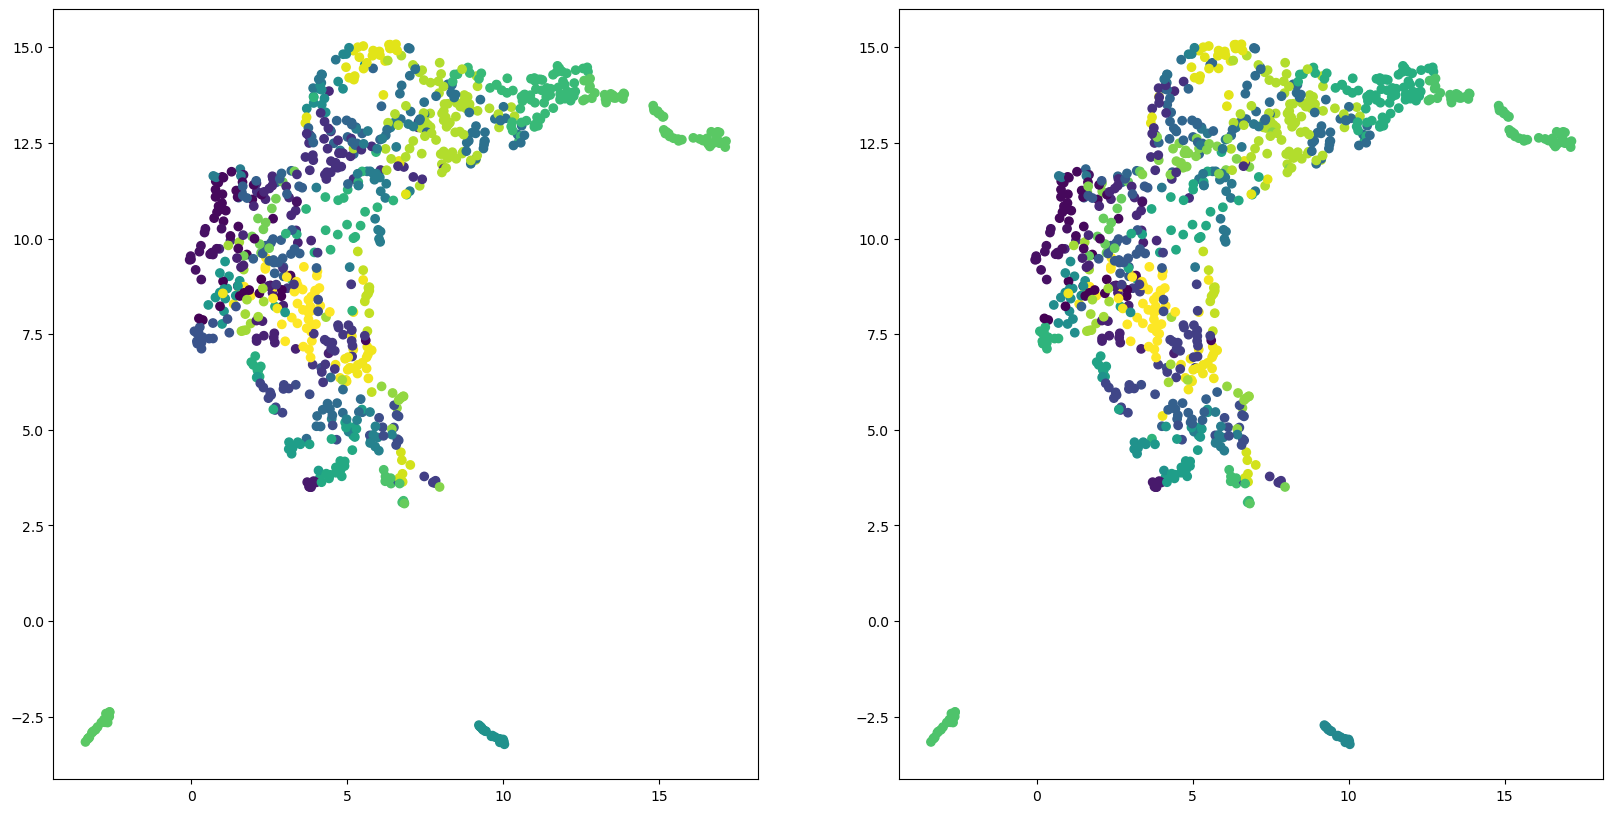

In [29]:
aff_prop = cluster.AffinityPropagation(damping=0.93)
aff_prop_labels = aff_prop.fit_predict(rheo_encoded)

fig, ax = plt.subplots(figsize=(20,10),ncols=2)
ax[0].scatter(embedding[:,0],embedding[:,1],c=aff_prop_labels)
ax[1].scatter(embedding[:,0],embedding[:,1],c=aff_prop_labels_original)
